<a href="https://colab.research.google.com/github/LxNexis/RM_SalaryPrediction/blob/main/RM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sb
import re
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, recall_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

In [ ]:
data = pd.read_csv('glassdoor_jobs.csv')

In [ ]:
data

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini"
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,Colleges & Universities,Education,Unknown / Non-Applicable,-1
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1
954,954,Data Engineer,-1,Loading...\n\nTitle: Data Engineer\n\nLocation...,4.8,IGNW\n4.8,"Austin, TX","Portland, OR",201 to 500 employees,2015,Company - Private,IT Services,Information Technology,$25 to $50 million (USD),Slalom


In [ ]:
def extract_median(salary_range):
    # Use regular expression to find the numbers
    match = re.findall(r'\d+', salary_range)
    if len(match) >= 2 and '-1' not in salary_range:
        # Convert the matched strings to integers
        lower_bound = int(match[0]) * 1000
        upper_bound = int(match[1]) * 1000
        # Calculate the median
        median_salary = (lower_bound + upper_bound) // 2
        return median_salary
    return None

def clean_revenue(revenue):
    if pd.isnull(revenue) or 'Unknown' in revenue:
        return np.nan
    revenue = revenue.replace(' (USD)', '').replace('$', '').replace(' ', '').replace('+', '')

    # Handle "Less than $1 Million" case
    if 'Less than' in revenue:
        if 'million' in revenue:
            return 0.5 * 1e6  # assuming average less than 1 million as 500k
        elif 'billion' in revenue:
            return 0.5 * 1e9  # assuming average less than 1 billion as 500M

    revenue = revenue.replace('billion', 'B').replace('million', 'M').replace('B', 'e9').replace('M', 'e6')

    try:
        if 'to' in revenue:
            low, high = revenue.split('to')
            low = float(low)
            high = float(high)
            return (low + high) / 2
        else:
            return float(revenue)
    except ValueError:
        return np.nan

def clean_size(size):
    if pd.isnull(size) or size == 'Unknown':
        return np.nan
    size = size.replace(' employees', '')
    if '+' in size:
        size = size.replace('+', '')
        return int(size)
    elif 'to' in size:
        low, high = size.split(' to ')
        return (int(low) + int(high)) / 2
    else:
        return int(size)

def extract_title(title):
    title = title.lower()

    core_titles = [
        "data scientist", "data engineer", "data analyst", "research scientist",
        "machine learning engineer", "business intelligence analyst", "software engineer",
        "clinical data scientist", "principal data scientist", "customer data scientist",
        "scientist", "senior data scientist", "staff data scientist", "lead data scientist",
        "quantitative analyst", "biomedical scientist", "analytics manager", "data science manager"
    ]

    seniority = re.findall(r'\b(senior|lead|staff|principal|junior|associate|manager|director|chief|vp|consultant|consulting|intern)\b', title)
    seniority = " ".join(seniority).strip()

    for core_title in core_titles:
        if core_title in title:
            return f"{core_title.capitalize()} {seniority}".strip()

    return title.capitalize()

def extract_name(name):
  cleaned_string = name.split('\n')[0]
  # print(cleaned_string)
  return cleaned_string

def extract_location(locate):
  cleaned_location = locate.split(',')[0]
  return cleaned_location

In [ ]:
data['MedianSalary'] = data['Salary Estimate'].apply(extract_median)
data['CleanedSize'] = data['Size'].apply(clean_size)
data['CleanedRevenue'] = data['Revenue'].apply(clean_revenue)
data['CleanedJobTitle'] = data['Job Title'].apply(extract_title)
# data['CleanedCompanyName'] = data['Company Name'].apply(extract_name)
# data['CleanedLocation'] = data['Location'].apply(extract_location)
# data['CleanedHeadquarters'] = data['Headquarters'].apply(extract_location)
data

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,MedianSalary,CleanedSize,CleanedRevenue,CleanedJobTitle
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,72000.0,750.5,5.000002e+07,Data scientist
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,87500.0,10000.0,2.500000e+09,Data scientist
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,85000.0,750.5,2.500000e+08,Data scientist
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",76500.0,3000.5,7.500000e+08,Data scientist
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",114500.0,125.5,NaN,Data scientist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini",102500.0,3000.5,2.500000e+08,Data engineer senior
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,Colleges & Universities,Education,Unknown / Non-Applicable,-1,73500.0,750.5,NaN,Scientist
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1,127500.0,25.5,5.000002e+06,Data science manager manager
954,954,Data Engineer,-1,Loading...\n\nTitle: Data Engineer\n\nLocation...,4.8,IGNW\n4.8,"Austin, TX","Portland, OR",201 to 500 employees,2015,Company - Private,IT Services,Information Technology,$25 to $50 million (USD),Slalom,NaN,350.5,2.500001e+07,Data engineer


In [ ]:
median = data['MedianSalary'].describe()
median

,MedianSalary
count,742.000000
mean,100626.010782
std,38855.948157
min,13500.000000
25%,73500.000000
50%,97500.000000
75%,122500.000000
max,254000.000000


In [ ]:
data['Industry'].nunique()

63

In [ ]:
# # for python
# data['Python_yn'] = data['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)

# data['R Studio'] = data['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() or 'r_studio' in x.lower() else 0)

# # For Spark
# data['Spark'] = data['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)

# # For AWS
# data['AWS_yn'] = data['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)

# # For Excel
# data['Excel_yn'] = data['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

In [ ]:
data = data.drop(columns=['Unnamed: 0','Salary Estimate', 'Size', 'Job Description', 'Revenue', 'Company Name', 'Competitors', 'Job Title'])

In [ ]:
data

,Rating,Location,Headquarters,Founded,Type of ownership,Industry,Sector,MedianSalary,CleanedSize,CleanedRevenue,CleanedJobTitle
0,3.8,"Albuquerque, NM","Goleta, CA",1973,Company - Private,Aerospace & Defense,Aerospace & Defense,72000.0,750.5,5.000002e+07,Data scientist
1,3.4,"Linthicum, MD","Baltimore, MD",1984,Other Organization,Health Care Services & Hospitals,Health Care,87500.0,10000.0,2.500000e+09,Data scientist
2,4.8,"Clearwater, FL","Clearwater, FL",2010,Company - Private,Security Services,Business Services,85000.0,750.5,2.500000e+08,Data scientist
3,3.8,"Richland, WA","Richland, WA",1965,Government,Energy,"Oil, Gas, Energy & Utilities",76500.0,3000.5,7.500000e+08,Data scientist
4,2.9,"New York, NY","New York, NY",1998,Company - Private,Advertising & Marketing,Business Services,114500.0,125.5,NaN,Data scientist
...,...,...,...,...,...,...,...,...,...,...,...
951,4.4,"Nashville, TN","San Francisco, CA",2006,Company - Public,Internet,Information Technology,102500.0,3000.5,2.500000e+08,Data engineer senior
952,2.6,"Pittsburgh, PA","Pittsburgh, PA",1984,College / University,Colleges & Universities,Education,73500.0,750.5,NaN,Scientist
953,3.2,"Allentown, PA","Chadds Ford, PA",-1,Company - Private,Staffing & Outsourcing,Business Services,127500.0,25.5,5.000002e+06,Data science manager manager
954,4.8,"Austin, TX","Portland, OR",2015,Company - Private,IT Services,Information Technology,NaN,350.5,2.500001e+07,Data engineer


In [ ]:
data["MedianSalary"] = data["MedianSalary"].fillna(data["MedianSalary"].mean())
data["CleanedRevenue"] = data["CleanedRevenue"].fillna(data["CleanedRevenue"].mean())

In [ ]:
data.duplicated().sum()

372

In [ ]:
data = data.drop_duplicates()

In [ ]:
numerical_columns = data.select_dtypes(exclude=['object']).columns

for x in numerical_columns:
  upperLimit = data[x].std() * 3 + data[x].mean()
  lowerLimit = data[x].mean() - data[x].std() * 3
  data = data.loc[(data[x] <= upperLimit) & (data[x] >= lowerLimit)]

In [ ]:
data.describe()

,Rating,Founded,MedianSalary,CleanedSize,CleanedRevenue
count,516.000000,516.000000,516.000000,516.000000,5.160000e+02
mean,3.810465,1975.955426,99285.560187,3022.613372,2.640559e+09
std,0.601460,50.550023,31664.274263,3632.108282,3.210222e+09
min,1.900000,1744.000000,13500.000000,25.500000,2.500000e+06
25%,3.400000,1967.000000,81000.000000,350.500000,2.500000e+08
50%,3.800000,1996.000000,100626.010782,750.500000,2.500000e+09
75%,4.300000,2008.000000,112500.000000,3000.500000,2.709877e+09
max,5.000000,2019.000000,194500.000000,10000.000000,1.000000e+10


In [ ]:
data = pd.get_dummies(data, columns=['CleanedJobTitle','Type of ownership', 'Sector', 'Industry', 'Location', 'Headquarters'], prefix='is')

In [ ]:
for column in data.columns:
    if column.startswith('is_'):
        data[column] = data[column].astype(int)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516 entries, 0 to 948
Columns: 610 entries, Rating to is_Zurich, Switzerland
dtypes: float64(4), int64(606)
memory usage: 2.4 MB


In [ ]:
data

,Rating,Founded,MedianSalary,CleanedSize,CleanedRevenue,is_Analytics consultant,is_Analytics manager manager,"is_Assistant director/director, office of data science","is_Associate, data science, internal audit",is_Atl - data & analytics (da),...,"is_West Hills, CA","is_West Palm Beach, FL","is_Westlake Village, CA","is_Wilsonville, OR","is_Winston-Salem, NC","is_Winter Park, FL","is_Woburn, MA","is_Woodinville, WA","is_Worcester, MA","is_Zurich, Switzerland"
0,3.8,1973,72000.000000,750.5,5.000002e+07,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.4,1984,87500.000000,10000.0,2.500000e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.8,2010,85000.000000,750.5,2.500000e+08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.8,1965,76500.000000,3000.5,7.500000e+08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.9,1998,114500.000000,125.5,2.709877e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,4.7,2013,100626.010782,25.5,2.709877e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
925,3.3,1994,100626.010782,125.5,5.000002e+07,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
928,4.0,2006,92000.000000,750.5,2.709877e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
945,4.1,2007,111000.000000,25.5,2.709877e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.describe()

,Rating,Founded,MedianSalary,CleanedSize,CleanedRevenue,is_Analytics consultant,is_Analytics manager manager,"is_Assistant director/director, office of data science","is_Associate, data science, internal audit",is_Atl - data & analytics (da),...,"is_West Hills, CA","is_West Palm Beach, FL","is_Westlake Village, CA","is_Wilsonville, OR","is_Winston-Salem, NC","is_Winter Park, FL","is_Woburn, MA","is_Woodinville, WA","is_Worcester, MA","is_Zurich, Switzerland"
count,516.000000,516.000000,516.000000,516.000000,5.160000e+02,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,3.810465,1975.955426,99285.560187,3022.613372,2.640559e+09,0.001938,0.013566,0.001938,0.001938,0.001938,...,0.003876,0.001938,0.003876,0.001938,0.009690,0.001938,0.003876,0.001938,0.005814,0.003876
std,0.601460,50.550023,31664.274263,3632.108282,3.210222e+09,0.044023,0.115792,0.044023,0.044023,0.044023,...,0.062197,0.044023,0.062197,0.044023,0.098054,0.044023,0.062197,0.044023,0.076101,0.062197
min,1.900000,1744.000000,13500.000000,25.500000,2.500000e+06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.400000,1967.000000,81000.000000,350.500000,2.500000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.800000,1996.000000,100626.010782,750.500000,2.500000e+09,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.300000,2008.000000,112500.000000,3000.500000,2.709877e+09,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,2019.000000,194500.000000,10000.000000,1.000000e+10,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
corr = data.corr()
abss_cor = abs(corr["MedianSalary"])
high_cor = abss_cor[abss_cor > 0.0]
chosen_feature = [col for col in data.columns if col in high_cor]
chosen_feature.remove('MedianSalary')
print(chosen_feature)

['Rating', 'Founded', 'CleanedSize', 'CleanedRevenue', 'is_Analytics consultant', 'is_Analytics manager manager', 'is_Assistant director/director, office of data science', 'is_Associate, data science, internal audit', 'is_Atl - data & analytics (da)', 'is_Business development - data supply partnerships (veraset)', 'is_Business intelligence analyst', 'is_Chief data officer', 'is_Clinical data manager', 'is_Consultant - analytics consulting', 'is_Consultant– data analytics group', 'is_Data & analytics consultant (nyc)', 'is_Data analyst', 'is_Data analyst associate', 'is_Data analyst junior', 'is_Data analyst lead', 'is_Data analyst senior', 'is_Data analytics project manager', 'is_Data architect / data modeler', 'is_Data engineer', 'is_Data engineer associate', 'is_Data engineer associate director', 'is_Data engineer consultant', 'is_Data engineer intern', 'is_Data engineer lead', 'is_Data engineer principal', 'is_Data engineer senior', 'is_Data engineer staff', 'is_Data management spec

In [ ]:
X = data[chosen_feature]
Y = data['MedianSalary']

In [ ]:
data

,Rating,Founded,MedianSalary,CleanedSize,CleanedRevenue,is_Analytics consultant,is_Analytics manager manager,"is_Assistant director/director, office of data science","is_Associate, data science, internal audit",is_Atl - data & analytics (da),...,"is_West Hills, CA","is_West Palm Beach, FL","is_Westlake Village, CA","is_Wilsonville, OR","is_Winston-Salem, NC","is_Winter Park, FL","is_Woburn, MA","is_Woodinville, WA","is_Worcester, MA","is_Zurich, Switzerland"
0,3.8,1973,72000.000000,750.5,5.000002e+07,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.4,1984,87500.000000,10000.0,2.500000e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.8,2010,85000.000000,750.5,2.500000e+08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.8,1965,76500.000000,3000.5,7.500000e+08,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.9,1998,114500.000000,125.5,2.709877e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,4.7,2013,100626.010782,25.5,2.709877e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
925,3.3,1994,100626.010782,125.5,5.000002e+07,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
928,4.0,2006,92000.000000,750.5,2.709877e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
945,4.1,2007,111000.000000,25.5,2.709877e+09,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [ ]:
def wmape(actual, forecast, weights=None):
    actual = np.array(actual)
    forecast = np.array(forecast)

    if weights is None:
        weights = actual

    weights = np.array(weights)

    numerator = np.sum(weights * np.abs(forecast - actual))
    denominator = np.sum(weights * actual)

    wmape_value = (numerator / denominator) * 100
    return wmape_value

def smape(actual, forecast):
    # Convert inputs to numpy arrays
    actual = np.array(actual)
    forecast = np.array(forecast)

    # Calculate the numerator and denominator
    numerator = np.abs(forecast - actual)
    denominator = (np.abs(actual) + np.abs(forecast)) / 2

    # Calculate sMAPE
    smape_value = np.mean(numerator / denominator) * 100

    return smape_value

def relative_absolute_error(y_true, y_pred):
    y_mean = np.mean(y_true)

    abs_error_model = np.abs(y_true - y_pred)
    abs_error_baseline = np.abs(y_true - y_mean)

    rae = np.sum(abs_error_model) / np.sum(abs_error_baseline)
    return rae

Mean Absolute Error: 15720.12
Mean Absolute Percentage Error: 16.60%
R-squared Score: 0.35
Adjusted R-squared Score: 1.09
sMAPE: 15.74%
WMAPE: 15.79%
Relative Absolute Error (RAE): 0.822417689474609


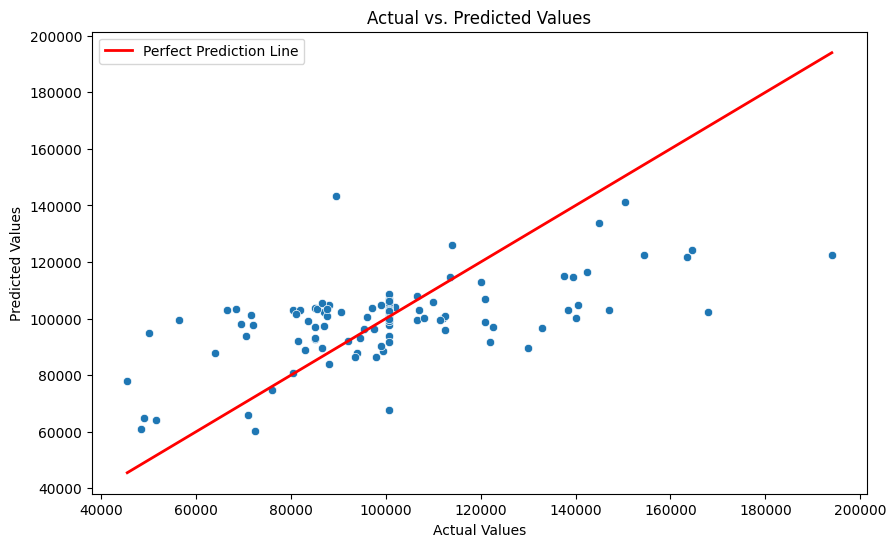

In [ ]:
RF = RandomForestRegressor(n_estimators=100, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(RF, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
RF.fit(XTrain, YTrain)

predictions = RF.predict(XTest)
mae = mean_absolute_error(YTest, predictions)
mape = mean_absolute_percentage_error(YTest, predictions) * 100
r2 = r2_score(YTest, predictions)
n = len(YTest)  # Number of observations
p = XTest.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')
rae = relative_absolute_error(YTest, predictions)
print(f"Relative Absolute Error (RAE): {rae}")

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest), max(predictions))
min_val = min(min(YTest), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

In [ ]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Create a RandomForestRegressor instance
# RF = RandomForestRegressor(random_state=42)

# # Create a GridSearchCV instance
# grid_search = GridSearchCV(estimator=RF,
#                            param_grid=param_grid,
#                            scoring='neg_mean_absolute_error',  # You can also use 'r2' or other metrics
#                            cv=5,
#                            n_jobs=-1,
#                            verbose=2)

# # Fit the GridSearchCV
# grid_search.fit(XTrain, YTrain)

# # Get the best parameters
# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_  # Since we used 'neg_mean_absolute_error'

# print("Best Parameters:", best_params)
# print("Best MAE Score:", best_score)

# # Use the best model to make predictions
# best_model = grid_search.best_estimator_
# predictions = best_model.predict(XTest)
# mae = mean_absolute_error(YTest, predictions)

# print(f"Mean Absolute Error of the Best Model: {mae:.2f}")

In [ ]:
# param_grid = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [10, 20, 30, 40, None],
#     'min_samples_split': [2, 4, 6, 8, 10],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Create a RandomForestRegressor instance
# RF = RandomForestRegressor(random_state=42)

# # Use KFold cross-validation with a higher number of splits
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# # Create a GridSearchCV instance with R-squared as the scoring metric
# grid_search = GridSearchCV(estimator=RF,
#                            param_grid=param_grid,
#                            scoring='r2',
#                            cv=kf,
#                            n_jobs=-1,
#                            verbose=2)

# # Fit the GridSearchCV
# grid_search.fit(XTrain, YTrain)

# # Get the best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best R-squared Score (CV):", best_score)

# # Use the best model to make predictions
# best_model = grid_search.best_estimator_
# predictions = best_model.predict(XTest)
# r2 = r2_score(YTest, predictions)

# print(f"R-squared Score of the Best Model (Test Set): {r2:.2f}")

In [ ]:
# model = AdaBoostRegressor(n_estimators=100, random_state=42)
# # kf = KFold(n_splits=5, shuffle=True, random_state=42)
# # scores = cross_val_score(model, X, Y, cv=kf)
# # print(f"Cross-validation scores: {scores}")
# # print(f"Mean cross-validation score: {np.mean(scores)}")
# model.fit(XTrain, YTrain)

# predictions = model.predict(XTest)
# mae = mean_absolute_error(YTest, predictions)
# mape = mean_absolute_percentage_error(YTest, predictions) * 100
# r2 = r2_score(YTest, predictions)
# n = len(YTest)  # Number of observations
# p = XTest.shape[1]  # Number of predictors
# adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# print(f"Mean Absolute Error: {mae:.2f}")
# print(f"Mean Absolute Percentage Error: {mape:.2f}%")
# print(f"R-squared Score: {r2:.2f}")
# print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
# smape_value = smape(YTest, predictions)
# print(f'sMAPE: {smape_value:.2f}%')
# wmape_value = wmape(YTest, predictions)
# print(f'WMAPE: {wmape_value:.2f}%')

# plt.figure(figsize=(10, 6))
# sb.scatterplot(x=YTest, y=predictions)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')
# max_val = max(max(YTest), max(predictions))
# min_val = min(min(YTest), min(predictions))
# plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

# plt.legend()
# plt.show()

In [ ]:
# model = GradientBoostingRegressor(n_estimators=100, random_state=42)
# # kf = KFold(n_splits=5, shuffle=True, random_state=42)
# # scores = cross_val_score(model, X, Y, cv=kf)
# # print(f"Cross-validation scores: {scores}")
# # print(f"Mean cross-validation score: {np.mean(scores)}")
# model.fit(XTrain, YTrain)

# predictions = model.predict(XTest)
# mae = mean_absolute_error(YTest, predictions)
# mape = mean_absolute_percentage_error(YTest, predictions) * 100
# r2 = r2_score(YTest, predictions)
# n = len(YTest)  # Number of observations
# p = XTest.shape[1]  # Number of predictors
# adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# print(f"Mean Absolute Error: {mae:.2f}")
# print(f"Mean Absolute Percentage Error: {mape:.2f}%")
# print(f"R-squared Score: {r2:.2f}")
# print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
# smape_value = smape(YTest, predictions)
# print(f'sMAPE: {smape_value:.2f}%')
# wmape_value = wmape(YTest, predictions)
# print(f'WMAPE: {wmape_value:.2f}%')

# plt.figure(figsize=(10, 6))
# sb.scatterplot(x=YTest, y=predictions)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')
# max_val = max(max(YTest), max(predictions))
# min_val = min(min(YTest), min(predictions))
# plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

# plt.legend()
# plt.show()

In [ ]:
# model = ExtraTreesRegressor(n_estimators=100, random_state=42)
# # kf = KFold(n_splits=5, shuffle=True, random_state=42)
# # scores = cross_val_score(model, X, Y, cv=kf)
# # print(f"Cross-validation scores: {scores}")
# # print(f"Mean cross-validation score: {np.mean(scores)}")
# model.fit(XTrain, YTrain)

# predictions = model.predict(XTest)
# mae = mean_absolute_error(YTest, predictions)
# mape = mean_absolute_percentage_error(YTest, predictions) * 100
# r2 = r2_score(YTest, predictions)
# n = len(YTest)  # Number of observations
# p = XTest.shape[1]  # Number of predictors
# adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# print(f"Mean Absolute Error: {mae:.2f}")
# print(f"Mean Absolute Percentage Error: {mape:.2f}%")
# print(f"R-squared Score: {r2:.2f}")
# print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
# smape_value = smape(YTest, predictions)
# print(f'sMAPE: {smape_value:.2f}%')
# wmape_value = wmape(YTest, predictions)
# print(f'WMAPE: {wmape_value:.2f}%')

# plt.figure(figsize=(10, 6))
# sb.scatterplot(x=YTest, y=predictions)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')
# max_val = max(max(YTest), max(predictions))
# min_val = min(min(YTest), min(predictions))
# plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

# plt.legend()
# plt.show()

In [ ]:
XTrain_array = XTrain.to_numpy()
XTest_array = XTest.to_numpy()
YTrain_array = YTrain.to_numpy()
YTest_array = YTest.to_numpy()

In [ ]:
# XGB = XGBRegressor(random_state=42)

# # Define the hyperparameter grid to search
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.3]
# }

# # Setup GridSearchCV
# grid_search = GridSearchCV(
#     estimator=XGB,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     scoring='neg_mean_absolute_error',
#     verbose=1
# )

# # Fit the grid search to the data
# grid_search.fit(XTrain_array, YTrain_array)

# # Best parameters found
# best_params = grid_search.best_params_
# print(f"Best parameters found: {best_params}")

# # Best model found
# best_XGB_model = grid_search.best_estimator_

# # Evaluate the best model on the test set
# predictions = best_XGB_model.predict(XTest_array)
# mae = mean_absolute_error(YTest_array, predictions)
# mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
# r2 = r2_score(YTest_array, predictions)
# n = len(YTest_array)  # Number of observations
# p = XTest_array.shape[1]  # Number of predictors
# adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# print(f"Mean Absolute Error: {mae:.2f}")
# print(f"Mean Absolute Percentage Error: {mape:.2f}%")
# print(f"R-squared Score: {r2:.2f}")
# print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
# smape_value = smape(YTest_array, predictions)
# print(f'sMAPE: {smape_value:.2f}%')
# wmape_value = wmape(YTest_array, predictions)
# print(f'WMAPE: {wmape_value:.2f}%')

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# sb.scatterplot(x=YTest_array, y=predictions)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')
# max_val = max(max(YTest_array), max(predictions))
# min_val = min(min(YTest_array), min(predictions))
# plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

# plt.legend()
# plt.show()

Mean Absolute Error: 15759.45
Mean Absolute Percentage Error: 15.93%
R-squared Score: 0.38
Adjusted R-squared Score: 1.08
sMAPE: 15.63%
WMAPE: 16.20%


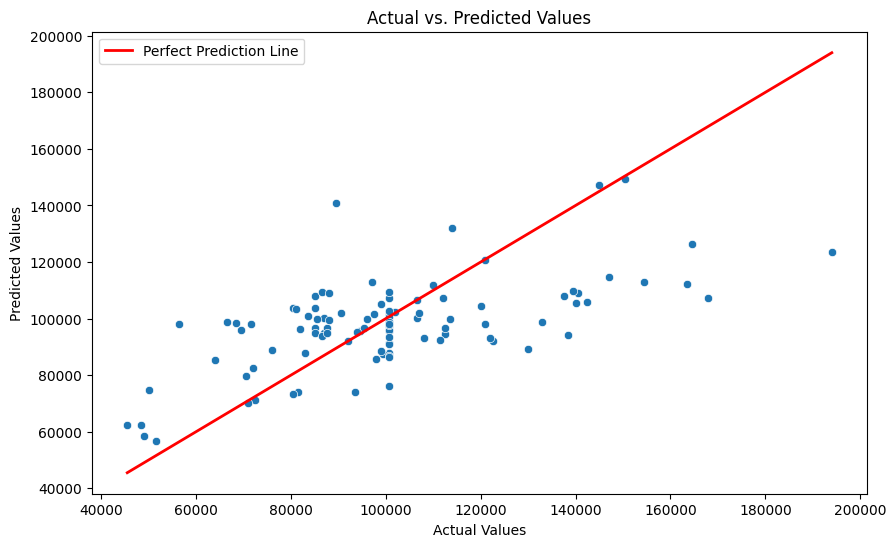

In [ ]:
XGB = XGBRegressor(n_estimators=100, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(XGB, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
XGB.fit(XTrain_array, YTrain_array)

predictions = XGB.predict(XTest_array)
mae = mean_absolute_error(YTest_array, predictions)
mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
r2 = r2_score(YTest_array, predictions)
n = len(YTest_array)  # Number of observations
p = XTest_array.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest_array, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest_array), max(predictions))
min_val = min(min(YTest_array), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

Mean Absolute Error: 15526.38
Mean Absolute Percentage Error: 16.28%
R-squared Score: 0.37
Adjusted R-squared Score: 1.08
sMAPE: 15.50%
WMAPE: 15.72%


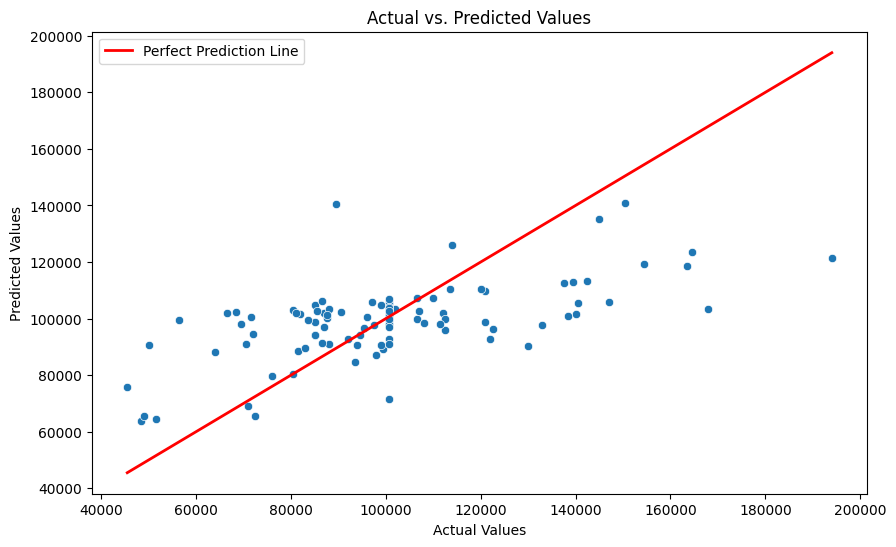

In [ ]:
base_models = [
    ('xgb', XGBRegressor(n_estimators=100, random_state = 42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state = 42))
]
Stack = StackingRegressor(estimators=base_models, final_estimator=Ridge())
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(Stack, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
Stack.fit(XTrain_array, YTrain_array)

predictions = Stack.predict(XTest_array)
mae = mean_absolute_error(YTest_array, predictions)
mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
r2 = r2_score(YTest_array, predictions)
n = len(YTest_array)  # Number of observations
p = XTest_array.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest_array, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest_array), max(predictions))
min_val = min(min(YTest_array), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

Mean Absolute Error: 15583.30
Mean Absolute Percentage Error: 15.91%
R-squared Score: 0.37
Adjusted R-squared Score: 1.08
sMAPE: 15.44%
WMAPE: 16.02%


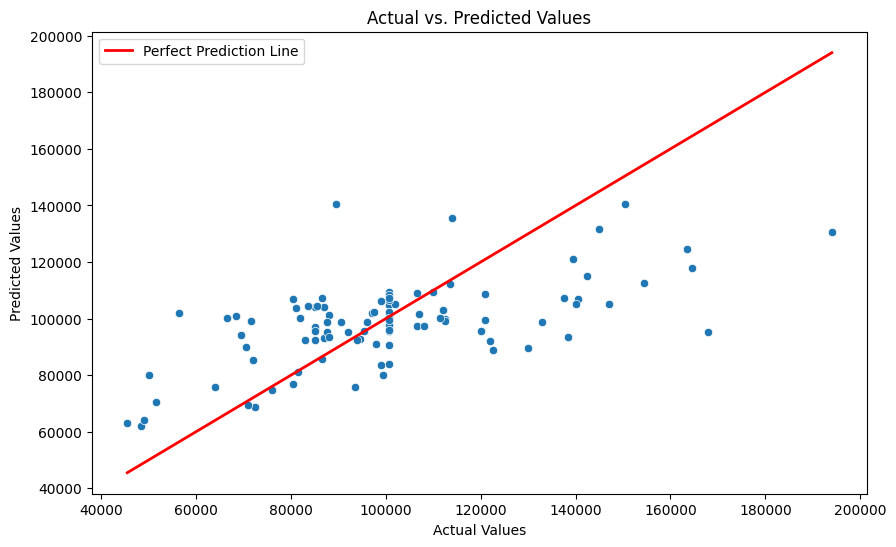

In [ ]:
base_regressor = XGBRegressor(n_estimators=100, random_state=42)
Bagging = BaggingRegressor(estimator=base_regressor, n_estimators=100, random_state=42)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(Bagging, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
Bagging.fit(XTrain_array, YTrain_array)
predictions = Bagging.predict(XTest_array)
mae = mean_absolute_error(YTest_array, predictions)
mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
r2 = r2_score(YTest_array, predictions)
n = len(YTest_array)  # Number of observations
p = XTest_array.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest_array, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest_array), max(predictions))
min_val = min(min(YTest_array), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()

Mean Absolute Error: 15376.64
Mean Absolute Percentage Error: 15.88%
R-squared Score: 0.38
Adjusted R-squared Score: 1.08
sMAPE: 15.32%
WMAPE: 15.67%


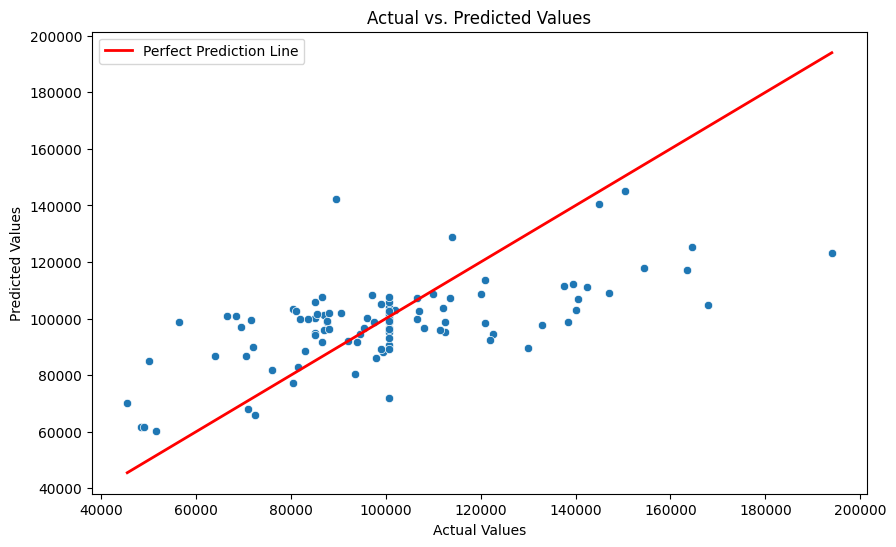

In [ ]:
regressor1 = XGBRegressor(n_estimators=100, random_state=42)
regressor2 = RandomForestRegressor(n_estimators=100, random_state=42)

Voting = VotingRegressor(estimators=[('lr', regressor1), ('rf', regressor2)])
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(Voting, X, Y, cv=kf)
# print(f"Cross-validation scores: {scores}")
# print(f"Mean cross-validation score: {np.mean(scores)}")
Voting.fit(XTrain_array, YTrain_array)

predictions = Voting.predict(XTest_array)
mae = mean_absolute_error(YTest_array, predictions)
mape = mean_absolute_percentage_error(YTest_array, predictions) * 100
r2 = r2_score(YTest_array, predictions)
n = len(YTest_array)  # Number of observations
p = XTest_array.shape[1]  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.2f}")
print(f"Adjusted R-squared Score: {adjusted_r2:.2f}")
smape_value = smape(YTest, predictions)
print(f'sMAPE: {smape_value:.2f}%')
wmape_value = wmape(YTest, predictions)
print(f'WMAPE: {wmape_value:.2f}%')

plt.figure(figsize=(10, 6))
sb.scatterplot(x=YTest_array, y=predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
max_val = max(max(YTest_array), max(predictions))
min_val = min(min(YTest_array), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, label='Perfect Prediction Line')

plt.legend()
plt.show()